# mag2exp: Inverse problems

This tutorial introduces the concept of solving inverse problems using `mag2exp`. It demonstrates the process of solving an inverse problem using `scipy` and `mag2exp`. Specifically, we will fit a Lorentz Transmission Electron Microscopy (LTEM) image of a skyrmion.

The objective is to use analytical modeling to fit the experimental TEM data accurately. This involves:

1. Loading and preprocessing the image.
2. Defining a suitable model for the skyrmion structure.
3. Simulating the LTEM defocus images.
4. Fitting the model using optimization techniques from `scipy`.
5. Visualizing the results.

The inverse problem we will demonstrate here involves deducing model parameters or system states from observed experimental data by leveraging the `mag2exp` Python package in conjunction with `scipy`.

In [1]:
from PIL import Image
import discretisedfield as df
import numpy as np
import mag2exp
from scipy.optimize import minimize

## Load the Image
To start, we will load our image of an isolated skyrmion. From the experiment, we know the following parameters:

- **Resolution**: 2 nm
- **Thickness of the sample**: 50 nm
- **Voltage**: 300 kV
- **Defocus**: 0.2 mm

In [2]:
image = np.load("isolated_skyrmion.npy")

We can have a look at our image using `discretisedfield`

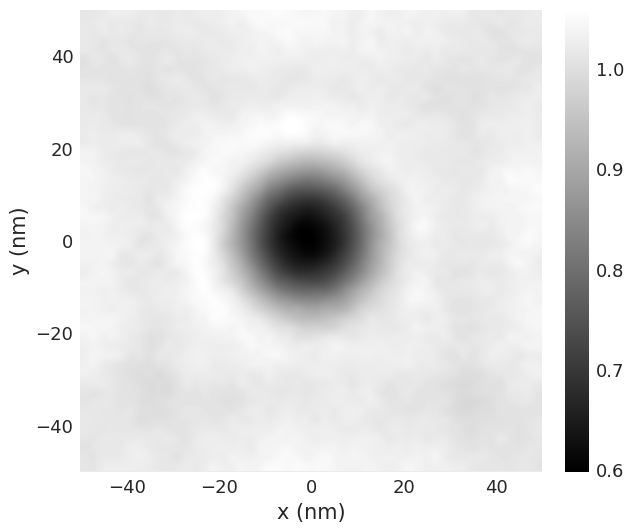

In [3]:
region = df.Region(p1=(-50e-9, -50e-9), p2=(50e-9, 50e-9))
mesh = df.Mesh(region=region, cell=(2e-9, 2e-9))
target = df.Field(mesh, nvdim=1, value=image)
target.mpl.scalar(cmap='grey', interpolation='spline16')

## Magnetization Model

We will define a mathematical model to fit the skyrmion structure in the image. For this purpose, we use a skyrmion ansatz for the magnetization, which captures the characteristic spin configuration of a skyrmion.

### Skyrmion Ansatz

The skyrmion ansatz describes the magnetization vector field $\mathbf{M}(x, y, z)$ of a skyrmion. The magnetization can be as:

$$
\mathbf{M}(\rho, \phi) = M_s \left( \sin \Theta(\rho) \cos \Phi(\phi), \sin \Theta(\rho) \sin \Phi(\phi), \cos \Theta(\rho) \right)
$$

Where:
- $M_s$ is the saturation magnetization.
- $\rho$ is the radius in polar coordinates
- $\phi$ is the polar angle
- $\Theta(\rho)$ and $\Phi(\phi)$ are functions that describe how the magnetisation varies as a function of $\rho$ and $\phi$ respectively

We will use a very simplistic solution with:
$$
\Phi(\phi) = \phi + \frac{\pi}{2}
$$
and
$$
\Theta(\rho) = \pi e^{-\rho/R}
$$
where $R$ is a characteristic length of a skyrmion.

We can use `discretisedfield` to create a plot of this anzatz.

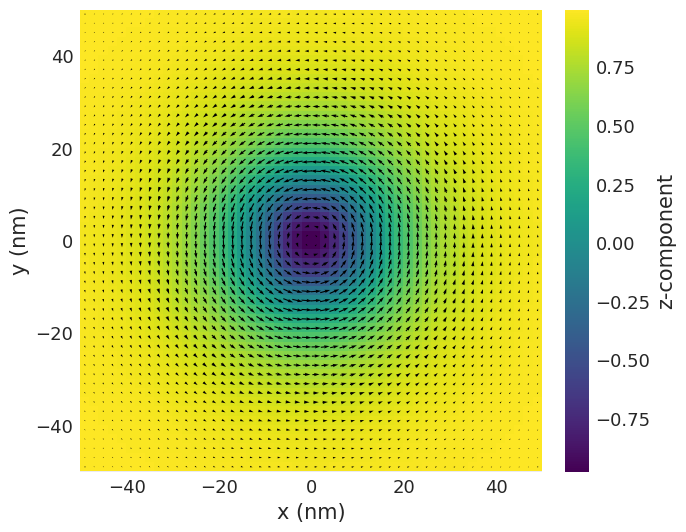

In [4]:
Ms = 350e3
region = df.Region(p1=(-50e-9, -50e-9, 0), p2=(50e-9, 50e-9, 50e-9))
mesh = df.Mesh(region=region, cell=(2e-9, 2e-9, 50e-9))

def skyrmion_anzatz(pos, R):
    x, y, _ = pos
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    
    m_theta = np.pi*np.exp(-rho/R)
    m_phi = phi + np.pi/2
    
    return np.array([np.sin(m_theta) * np.cos(m_phi), np.sin(m_theta) * np.sin(m_phi), np.cos(m_theta)])

field = df.Field(mesh, nvdim=3, value=lambda x: skyrmion_anzatz(x, R=20e-9), norm=Ms)
field.orientation.sel('z').mpl()

## Sinulate the defocus images
Here, we will simulate the LTEM defocus images, which are critical for fitting the skyrmion data.

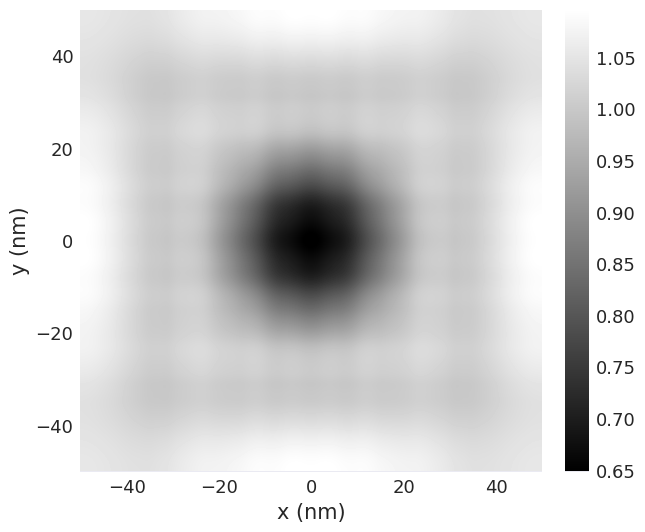

In [5]:
phase, _ = mag2exp.ltem.phase(field)
simulation = mag2exp.ltem.defocus_image(phase, voltage=300e3, df_length=0.2e-3)
simulation.mpl.scalar(cmap='grey', interpolation='spline16')

## Fitting the model

To fit the skyrmion model to the experimental data, we will define a mean squared error (MSE) function. This function evaluates the difference between the simulated LTEM defocus image and the target experimental image. The optimization process will aim to minimize this error by adjusting the model parameters.

In [6]:
def mse(x):
    R, Ms = x
    field = df.Field(mesh, nvdim=3, value=lambda x: skyrmion_anzatz(x, R=R), norm=Ms)
    phase, _ = mag2exp.ltem.phase(field)
    df_image = mag2exp.ltem.defocus_image(phase, voltage=300e3, df_length=0.2e-3)
    return ((df_image-target)**2).mean()

mse([20e-9, 350e3])

array([0.00110633])

To fit the skyrmion model to the experimental data, we will use the `minimize` function from `scipy.optimize`.
This function will adjust the skyrmion radius $R$ and saturation magnetization $M_s$ to minimize the mean squared error between the simulated and target images.

In [7]:
initial_guess = [20e-9, 300e3]  # Initial guesses: R in meters, Ms in A/m
results = minimize(mse, initial_guess, method='Nelder-Mead')
print(f"Optimized Skyrmion Radius: {results.x[0] * 1e9:.2f} nm")
print(f"Optimized Saturation Magnetization: {results.x[1] / 1e3:.2f} kA/m")

Optimized Skyrmion Radius: 14.02 nm
Optimized Saturation Magnetization: 368.92 kA/m


## Visualization and Validation
After optimization, it is crucial to visualize the fitted image against the target to assess the fit quality.

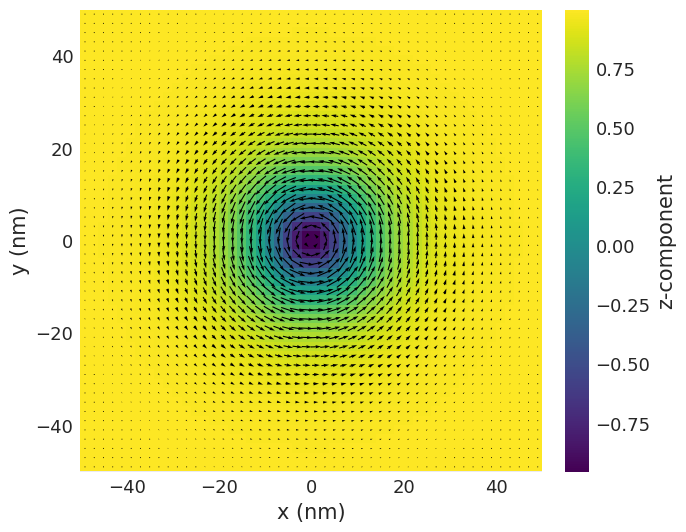

In [8]:
R, Ms = results.x
field = df.Field(mesh, nvdim=3, value=lambda x: skyrmion_anzatz(x, R=R), norm=Ms)
field.orientation.sel('z').mpl()

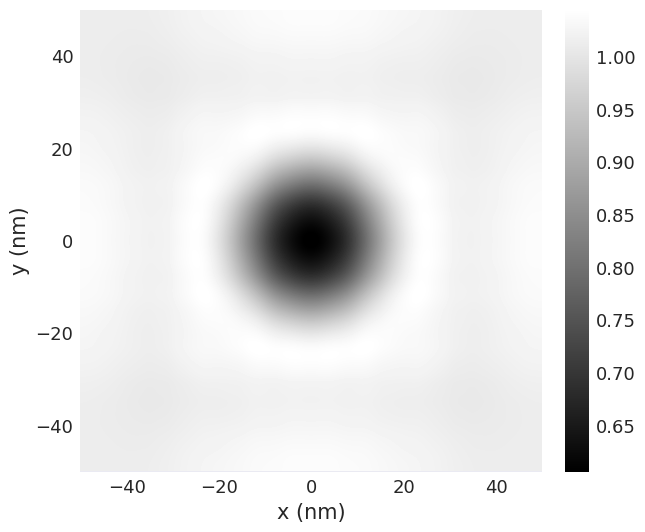

In [9]:
phase, _ = mag2exp.ltem.phase(field)
df_image = mag2exp.ltem.defocus_image(phase, voltage=300e3, df_length=0.2e-3)
df_image.mpl.scalar(cmap='grey', interpolation='spline16')

We can also look at the difference image to check the quality of the fit.

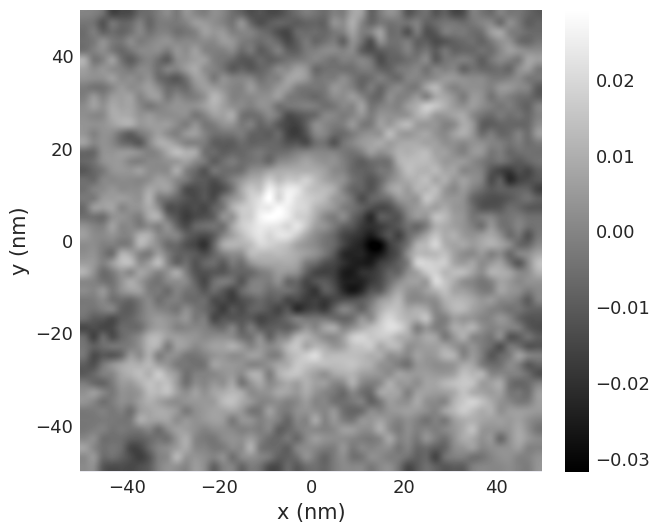

In [10]:
(df_image-target).mpl.scalar(cmap='grey', interpolation='spline16')